# Time Series Forecasting

Steps:

    1.) Understand the type of time series
    2.) Establish a prediction baseline
    3.) Build a prediction model

In [50]:
import pandas as pd
import numpy as np
import os

os.listdir(os.getcwd())

['.ipynb_checkpoints',
 'daily-total-female-births-in-cal.csv',
 'holidays_events.csv',
 'items.csv',
 'oil.csv',
 'sample_submission.csv',
 'stores.csv',
 'test.csv',
 'Time_series_forecasting.ipynb',
 'train.csv',
 'transactions.csv']

In [5]:
dtypes = {'id':'uint32', 'item_nbr':'int32', 'store_nbr':'int8', 'unit_sales':'float64', 'onpromotion': 'bool'}
train = pd.read_csv('train.csv',
                    usecols=[1, 2, 3, 4, 5],
                    dtype=dtypes,
                    parse_dates=['date'],
                    skiprows=range(1, 66458909))

# test = pd.read_csv('test.csv', 
#                    usecols=[0, 1, 2, 3, 4],
#                    dtype=dtypes, 
#                    parse_dates=["date"])

In [3]:
# Basic packages
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random as rd # generating random numbers
import datetime # manipulating date formats
# Viz
import matplotlib.pyplot as plt # basic plotting
import seaborn as sns # for prettier plots


# TIME SERIES
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

### 1.) Predict overall weekly sales 

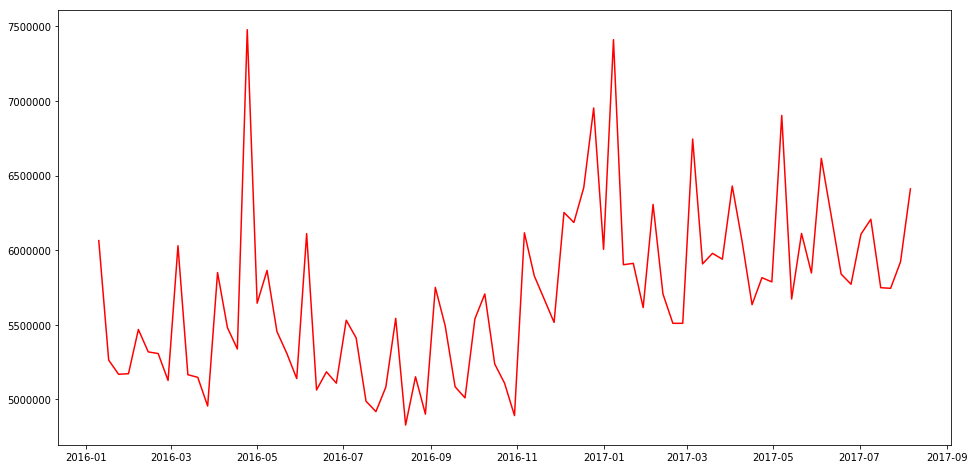

In [39]:
import matplotlib as mpl
ts = train.groupby(['date'])['unit_sales'].sum().resample('W').sum()[1:-2,]

fig = plt.figure(figsize = (16, 8))
ax = fig.add_subplot(111)
ax.plot_date(mpl.dates.date2num(ts.index), ts.values, 'r-')
plt.show()

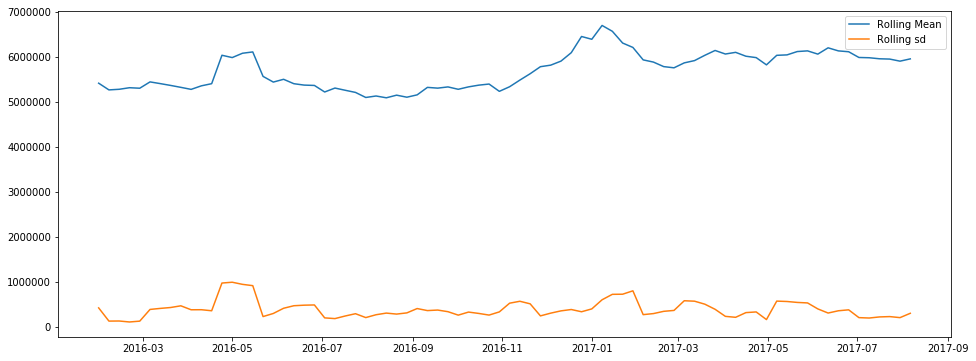

In [41]:
plt.figure(figsize=(16,6))
plt.plot(ts.rolling(window=4, center=False).mean(),label='Rolling Mean');
plt.plot(ts.rolling(window=4, center=False).std(),label='Rolling sd');
plt.legend()

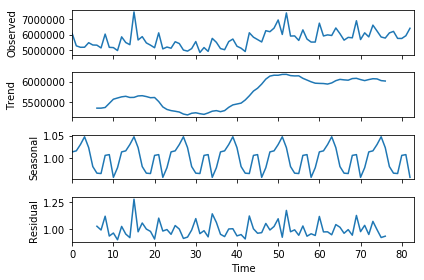

In [43]:
import statsmodels.api as sm
# multiplicative
res = sm.tsa.seasonal_decompose(ts.values,freq=12,model="multiplicative")
#plt.figure(figsize=(16,12))
fig = res.plot()
plt.show()

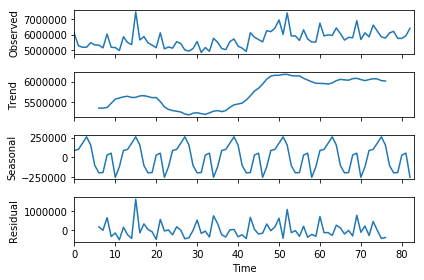

In [44]:
# Additive model
res = sm.tsa.seasonal_decompose(ts.values,freq=12,model="additive")
#plt.figure(figsize=(16,12))
fig = res.plot()
plt.show()

In [45]:
# Stationarity tests
def test_stationarity(timeseries):
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

test_stationarity(ts)

Results of Dickey-Fuller Test:
Test Statistic                 -1.967028
p-value                         0.301214
#Lags Used                      3.000000
Number of Observations Used    79.000000
Critical Value (5%)            -2.898886
Critical Value (1%)            -3.515977
Critical Value (10%)           -2.586694
dtype: float64


In [282]:
unique_stores = list(train['store_nbr'].unique())
unique_items = list(train['item_nbr'].unique())

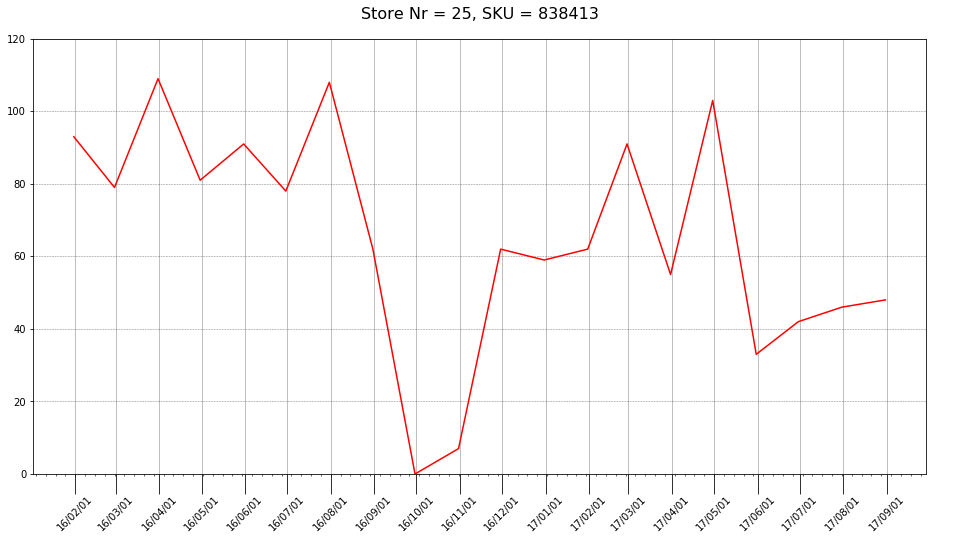

In [313]:
from matplotlib.dates import WeekdayLocator, YearLocator, MonthLocator, DateFormatter
from matplotlib.dates import MO, TU, WE, TH, FR, SA, SU

def plot_sales(storeNr, itemNr):
    x = train[(train['store_nbr'] == storeNr) & (train['item_nbr'] == itemNr)].groupby(['date'])['unit_sales'].sum().resample('M').sum().index
    y = train[(train['store_nbr'] == storeNr) & (train['item_nbr'] == itemNr)].groupby(['date'])['unit_sales'].sum().resample('M').sum().values

    fig = plt.figure(figsize = (16, 8))
    ax = fig.add_subplot(111)
    ax.set_title('Store Nr = {}, SKU = {}'.format(storeNr, itemNr), pad = 20, fontdict = {'fontsize': 16})
    ax.plot_date(mpl.dates.date2num(x), y, 'r-')
    ax.set_ylim(0, max(y)*1.1)
#     ax.set_xlim(x[0], x[-1])
    ax.xaxis.set_major_locator(MonthLocator())
    ax.xaxis.set_major_formatter(DateFormatter('%y/%m/%d'))
    ax.xaxis.set_minor_locator(WeekdayLocator(byweekday=MO))
    ax.tick_params(axis = 'x', which = 'major', direction = 'out', length = 20, pad = 0, labelrotation = 45)
    ax.tick_params(axis = 'x', which = 'minor')
    ax.grid(axis = 'x', which = 'major', color='k', linestyle='-', linewidth=0.5, alpha=0.5)
    ax.grid(axis = 'y', which = 'major', color='k', linestyle='--', linewidth=0.5, alpha=0.5)
    
plot_sales(storeNr = 25, itemNr = 838413)

## Time Series as Supervised Learning

### 1.) Sliding window method

In [163]:
# ts is total sale for all stores all products
ts = train.groupby(['date'])['unit_sales'].sum().resample('W').sum()

In [232]:
ts_df = train.groupby(['date'])['unit_sales'].sum().to_frame(name = 't+1')/1000
ts_df['t'] = ts_df['t+1'].shift(periods = 1)
ts_df['t-1'] = ts_df['t+1'].shift(periods = 2)
ts_df['t-2'] = ts_df['t+1'].shift(periods = 3)
# ts_df['t-4'] = ts_df['t+1'].shift(periods = 4)

ts_df.dropna(inplace = True)
ts_df.drop(ts_df.index[0], inplace = True)
# rolling window statistics
# ts_df['MA_7'] = ts_df['t+1'].shift(periods = 2).rolling(window = 7).mean()
# ts_df['MA_14'] = ts_df['t+1'].shift(periods = 2).rolling(window = 14).mean()
ts_df

,t+1,t,t-1,t-2
date,,,,
2016-01-05,835.305439,955.956875,1226.735718,1066.677424
2016-01-06,821.685656,835.305439,955.956875,1226.735718
2016-01-07,653.504367,821.685656,835.305439,955.956875
2016-01-08,713.608334,653.504367,821.685656,835.305439
2016-01-09,989.208458,713.608334,653.504367,821.685656
2016-01-10,1094.693837,989.208458,713.608334,653.504367
2016-01-11,705.495241,1094.693837,989.208458,713.608334
2016-01-12,647.057461,705.495241,1094.693837,989.208458
2016-01-13,660.045317,647.057461,705.495241,1094.693837


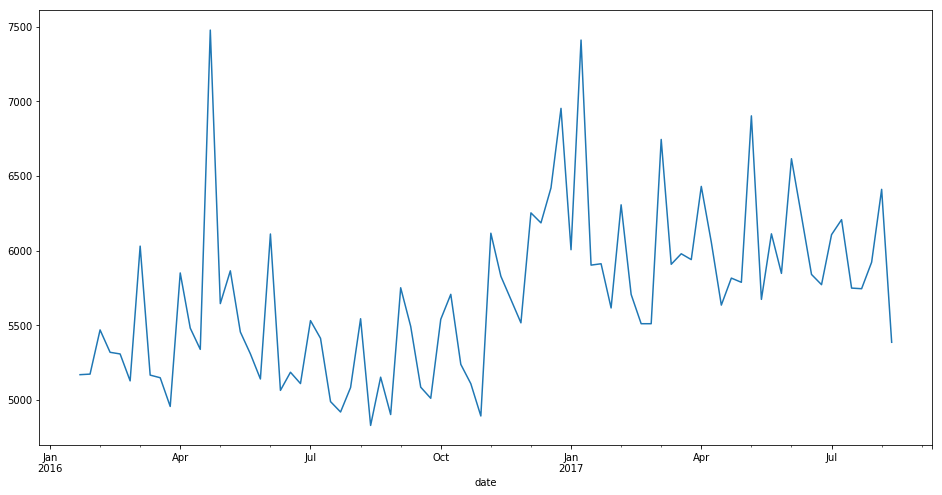

In [225]:
plt.figure(figsize =(16, 8))
ts_df['t+1'].plot()
plt.show()

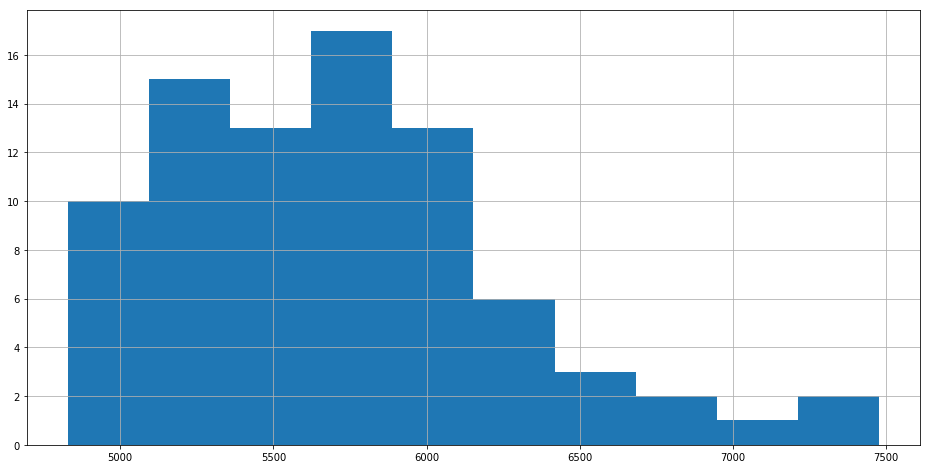

In [226]:
ts_df['t+1'].hist(figsize = (16, 8))
plt.show()

In [209]:
X = ts_df['t+1'].values
split = int(len(X) / 2)
X1, X2 = X[0:split], X[split:]
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()
print('mean1=%.2f, mean2=%.2f' % (mean1, mean2))
print('variance1=%.2f, variance2=%.2f' % (var1, var2))

mean1=5367.33, mean2=6039.73
variance1=208415.24, variance2=182617.54


In [227]:
from statsmodels.tsa.stattools import adfuller
X = ts_df['t+1'].values
result = adfuller(X)

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.054704
p-value: 0.263114
Critical Values:
	5%: -2.899
	1%: -3.517
	10%: -2.587


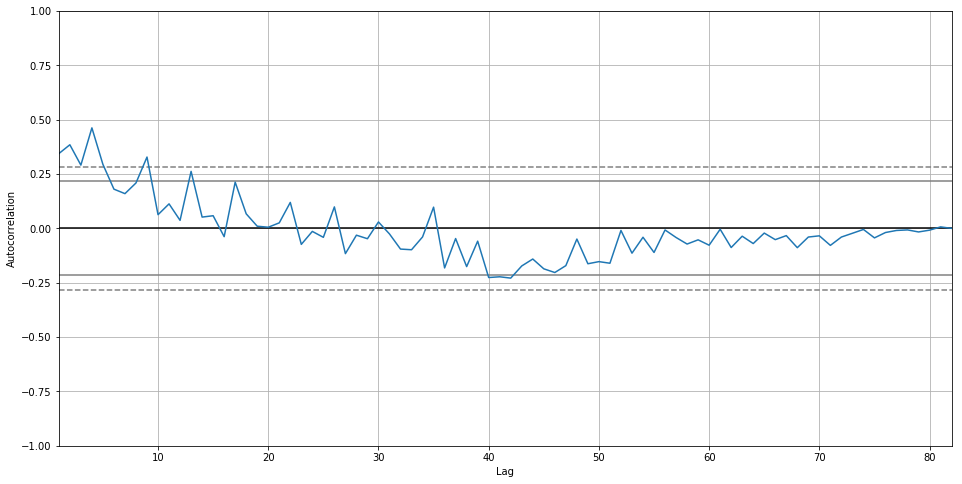

In [218]:
from pandas import read_csv
from pandas.plotting import autocorrelation_plot

plt.figure(figsize=(16, 8))
autocorrelation_plot(ts_df['t+1'])
plt.show()

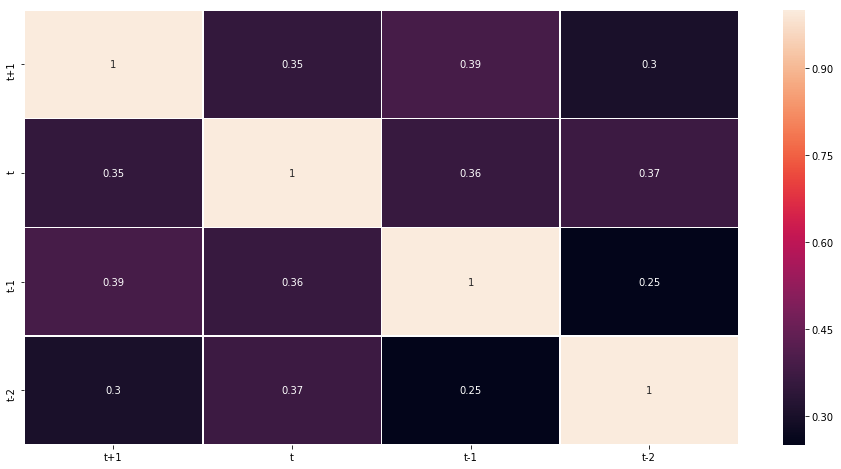

In [219]:
import seaborn as sns
corr = ts_df.corr().round(decimals = 2)

fig = plt.figure(figsize = (16, 8))
ax = fig.add_subplot(111)
ax = sns.heatmap(corr, annot=True, linewidths=.5)
plt.show()

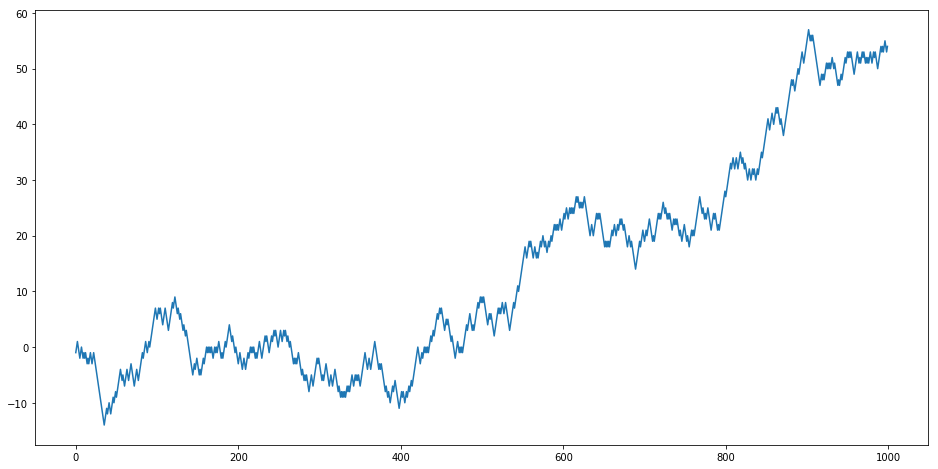

In [129]:
# Random walk
from random import seed
from random import random

seed(1)
random_walk = list()
random_walk.append(-1 if random() < 0.5 else 1)
for i in range(1, 1000):
    movement = -1 if random() < 0.5 else 1
    value = random_walk[i-1] + movement
    random_walk.append(value)

plt.figure(figsize=(16, 8))
plt.plot(random_walk)
plt.show()

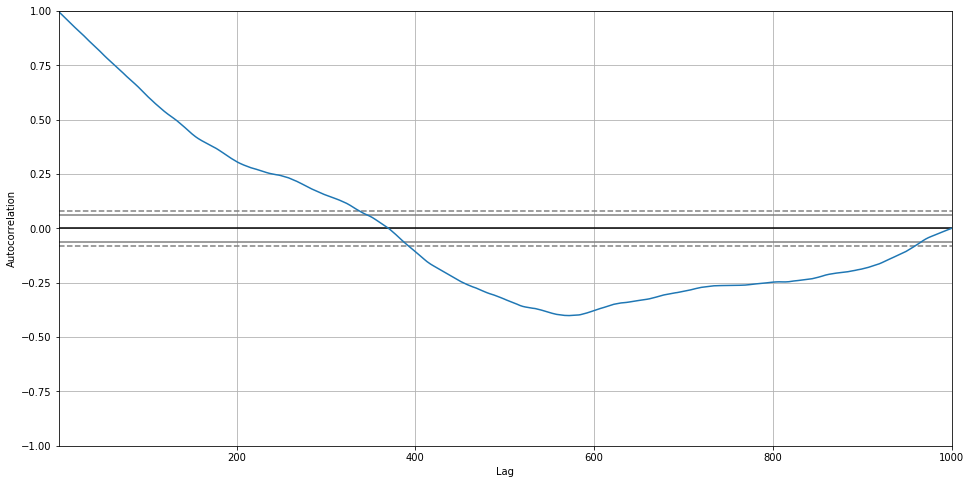

In [130]:
# plot the autocorrelation of a random walk
from random import seed
from random import random

from pandas.plotting import autocorrelation_plot

seed(1)
random_walk = list()
random_walk.append(-1 if random() < 0.5 else 1)

for i in range(1, 1000):
    movement = -1 if random() < 0.5 else 1
    value = random_walk[i-1] + movement
    random_walk.append(value)


plt.figure(figsize=(16, 8))
autocorrelation_plot(random_walk)
plt.show()

In [132]:
from random import seed
from random import random
from statsmodels.tsa.stattools import adfuller

# generate random walk
seed(1)
random_walk = list()
random_walk.append(-1 if random() < 0.5 else 1)
for i in range(1, 1000):
    movement = -1 if random() < 0.5 else 1
    value = random_walk[i-1] + movement
    random_walk.append(value)

# statistical test
result = adfuller(random_walk)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: 0.341605
p-value: 0.979175
Critical Values:
	5%: -2.864
	1%: -3.437
	10%: -2.568


In [136]:
result = adfuller(ts_df['t+1'].values)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.248037
p-value: 0.017367
Critical Values:
	5%: -2.867
	1%: -3.442
	10%: -2.569


                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   81
Model:                 ARIMA(3, 1, 0)   Log Likelihood                -614.722
Method:                       css-mle   S.D. of innovations            475.384
Date:                Fri, 29 Jun 2018   AIC                           1239.444
Time:                        13:01:38   BIC                           1251.416
Sample:                             1   HQIC                          1244.247
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.4439     19.941      0.373      0.710     -31.640      46.527
ar.L1.D.y     -0.7700      0.102     -7.546      0.000      -0.970      -0.570
ar.L2.D.y     -0.5176      0.120     -4.322      0.0

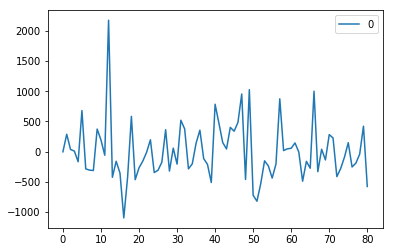

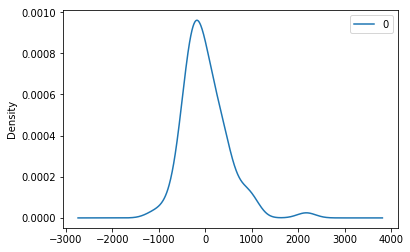

                 0
count    81.000000
mean      2.079653
std     478.571147
min   -1098.861016
25%    -286.780632
50%     -93.370172
75%     225.045235
max    2174.903227


In [228]:
from statsmodels.tsa.arima_model import ARIMA

# fit model
model = ARIMA(ts_df['t+1'].values, order=(3,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

# plot residual errors
residuals = DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

### Time Series as Supervised Machine Learning

In [9]:
# Load libraries
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

In [212]:
ts_df.shape[0]

82

In [213]:
# Train test split
ts_df.dropna(inplace = True)
y_train, y_test = ts_df['t+1'].iloc[:70].values, ts_df['t+1'].iloc[70:].values
X_train, X_test  = ts_df.iloc[:70, 1:].values, ts_df.iloc[70:, 1:].values

# ALTERNATIVE:
# train_size = int(len(X) * 0.66)
# train, test = X[0:train_size], X[train_size:len(X)]

In [224]:
# Spot-Check Algorithms
models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor(n_neighbors = 10)))
models.append(('CART', DecisionTreeRegressor()))
models.append(('RF', RandomForestRegressor()))
models.append(('ET', ExtraTreesRegressor()))
models.append(('ADA', AdaBoostRegressor()))
models.append(('SVR', SVR()))

# evaluate each model in turn
results = []
names = []

for name, model in models:
    splits = TimeSeriesSplit(n_splits=10)
    cv_results = cross_val_score(model, X_train, y_train, cv=splits, scoring='neg_mean_squared_log_error')
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: -0.012850 (0.014474)
LASSO: -0.012849 (0.014473)
EN: -0.012849 (0.014473)
KNN: -0.009954 (0.007957)
CART: -0.016340 (0.009437)
RF: -0.016086 (0.010353)
ET: -0.013333 (0.011132)
ADA: -0.017961 (0.014725)
SVR: -0.013297 (0.013170)


In [216]:
model = KNeighborsRegressor(n_neighbors = 10)
model.fit(X_train, y_train)
y_hat = model.predict(X_test)

In [189]:
# y_train, y_test = ts_df['t+1'].iloc[:450].values/1000, ts_df['t+1'].iloc[450:].values/1000
# X_train, X_test  = ts_df.iloc[:450, 1:].values/1000, ts_df.iloc[450:, 1:].values/1000

# Expanding window

n_train = 70
n_records = len(ts_df['t+1'])

y_hat_sw = []
model = ExtraTreesRegressor()

for i in range(n_train, n_records):
    X_train, y_train = ts_df.iloc[:i, 1:], ts_df['t+1'].iloc[:i]
    X_test = ts_df.iloc[i:i+1, 1:]
    
    model.fit(X_train, y_train)
    prediction = model.predict(X_test)
    y_hat_sw.append(prediction)

In [279]:
y_hat_sw = y_hat_sw[-128:-1]

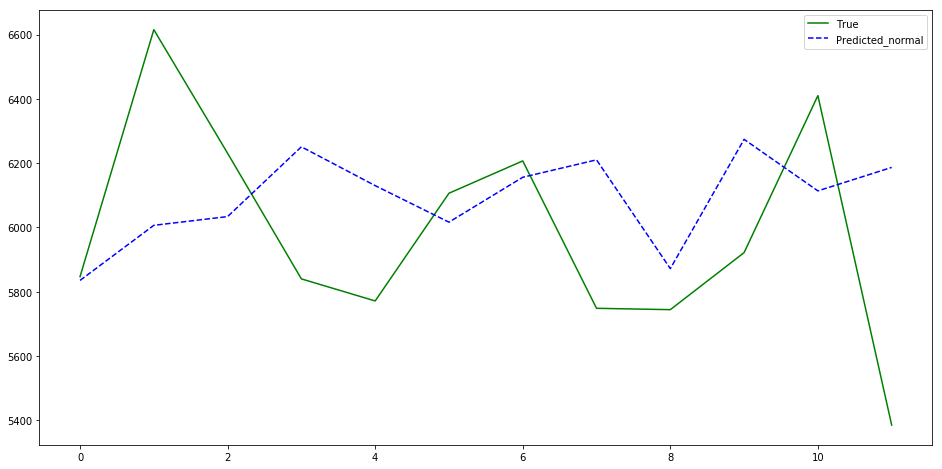

In [217]:
import matplotlib.pyplot as plt
plt.figure(figsize = (16, 8))
plt.plot(y_test, 'g-')
plt.plot(y_hat, 'b--')
# plt.plot(y_hat_sw, 'r--')
plt.legend(['True', 'Predicted_normal'])
plt.show()

### Time Series Decomposition

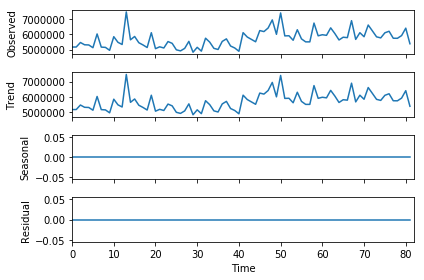

In [191]:
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot
series = np.array(ts_df['t+1'])
result = seasonal_decompose(series, model='additive', freq = 1)
result.plot()
plt.show()

### Removing trend

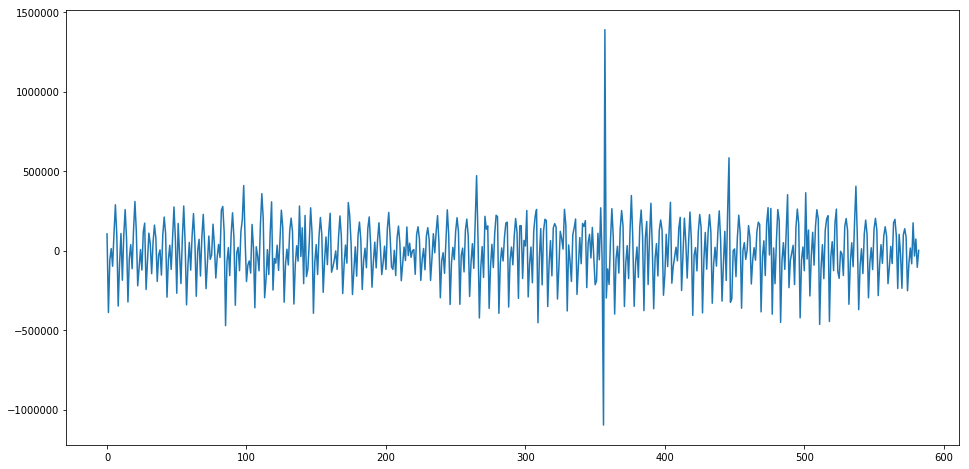

In [148]:
from pandas import datetime

X = ts_df['t+1'].values
diff = list()

for i in range(1, len(X)):
    value = X[i] - X[i - 1]
    diff.append(value)
    
plt.figure(figsize=(16, 8))
plt.plot(diff)
plt.show()

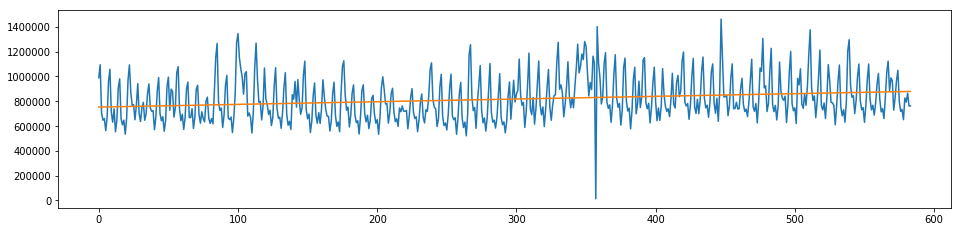

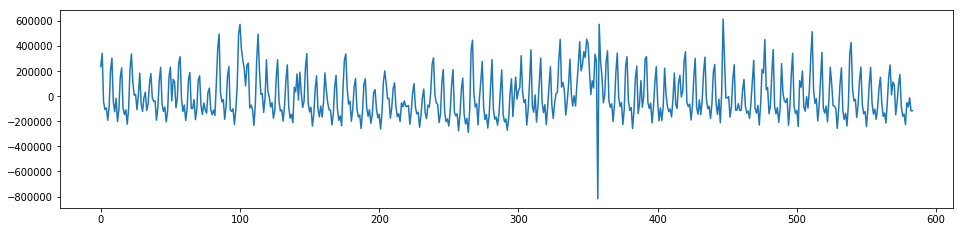

In [147]:
from sklearn.linear_model import LinearRegression
import numpy


# fit linear model
X = [i for i in range(0, len(ts_df['t+1']))]
X = numpy.reshape(X, (len(X), 1))
y = ts_df['t+1'].values
model = LinearRegression()
model.fit(X, y)

# calculate trend
trend = model.predict(X)

# plot trend
plt.figure(figsize=(16, 8))
plt.subplot(211)
plt.plot(y)
plt.plot(trend)
plt.show()

# detrend
detrended = [y[i]-trend[i] for i in range(0, len(ts_df['t+1']))]
# plot detrended
plt.figure(figsize=(16, 8))
plt.subplot(212)
plt.plot(detrended)
plt.show()

### Removing Seasonality

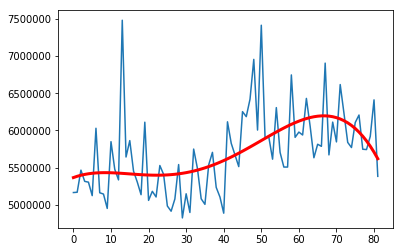

In [192]:
from numpy import polyfit

# fit polynomial: x^2*b1 + x*b2 + ... + bn
X = [i%365 for i in range(0, len(ts_df['t+1']))]
y = ts_df['t+1'].values

degree = 4
coef = polyfit(X, y, degree)

curve = list()

for i in range(len(X)):
    value = coef[-1]
    for d in range(degree):
        value += X[i]**(degree-d) * coef[d]
    curve.append(value)

# plot curve over original data
plt.plot(ts_df['t+1'].values)
plt.plot(curve, color='red', linewidth=3)
plt.show()

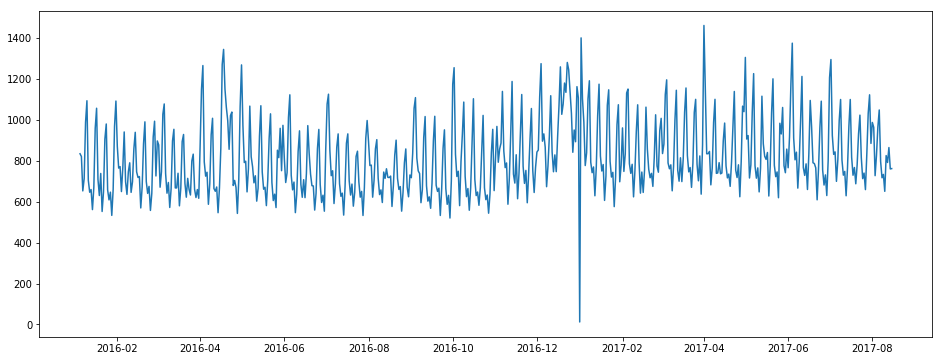

In [235]:
plt.figure(figsize = (16, 6))
plt.plot(ts_df['t+1'])
plt.show()

In [243]:
def calc_stock(series):
    initial_stock = series.rolling(window = 10).sum().dropna()[0]
    
    
    stock = initial_stock - series[i]


5847.138073000004

In [254]:
[7&i for i in range(len(ts_df['t+1'])-1)]

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 0,
 1,


In [250]:
for index, value in enumerate(ts_df['t+1']):
    

835.305439
821.685656
653.504367
713.608334
989.208458
1094.693837
705.495241
647.057461
660.045317
561.972623
671.0271
959.827147
1057.997343
709.78423
630.929751
738.744013
552.820769
648.430428
906.754834
980.927758
658.090687
609.465788
647.253678
533.709849
660.492758
969.938377
1093.211229
872.063315
765.233208
772.360939
650.328167
768.586508
941.954076
697.791631
636.542677
746.93964
790.988714
646.375371
698.15207
859.023027
940.214499
746.67129
719.111886
723.794722
570.072678
672.510134
883.790221
991.38427
698.907636
641.329061
675.573378
557.959328
641.922802
916.704069
994.502727
726.619758
897.927643
878.452365
671.564752
747.546796
1028.620677
1078.958509
738.126524
642.291345
694.645849
572.491857
664.893513
898.10111
954.98033
668.066393
668.183703
739.805378
580.452532
666.756819
895.038512
929.605582
690.469801
622.695837
714.881174
660.489845
633.5242
800.133517
833.336065
661.057866
621.166063
660.138989
617.374338
872.46732
1150.824581
1266.908292
795.237192
725.